In [1]:
%load_ext autoreload
%autoreload 2

# TODO: Think about plotting subset sizes against predicted probability? (confidence)

DATASET_NAME = "esnli"
LABEL_SPACE = ["entailment", "neutral", "contradiction"]
MODEL_NAME = "deberta-large"
SEED = 42
POOLER = "mean_with_attention"
LAYER = 24

In [13]:
# load embeddings
# from data.embeddings import load_saved_embeddings
# import numpy as np
# train_embeddings = load_saved_embeddings(
#     dataset=DATASET_NAME,
#     model=MODEL_NAME,
#     seed=SEED,
#     split="train",
#     pooler=POOLER,
#     layer=LAYER
# )

# eval_embeddings = load_saved_embeddings(
#     dataset=DATASET_NAME,
#     model=MODEL_NAME,
#     seed=SEED,
#     split="eval",
#     pooler=POOLER,
#     layer=LAYER
# )

# test_embeddings = load_saved_embeddings(
#     dataset=DATASET_NAME,
#     model=MODEL_NAME,
#     seed=SEED,
#     split="test",
#     pooler=POOLER,
#     layer=LAYER
# )

# train_eval_embeddings = np.vstack([train_embeddings, eval_embeddings])


# load classifier
from data.models import load_saved_wrapperbox_model
# knn_clf = load_saved_wrapperbox_model(
#     dataset=DATASET_NAME,
#     model=MODEL_NAME,
#     seed=SEED,
#     pooler=POOLER,
#     wrapperbox="KNN"
# )

# svm_clf = load_saved_wrapperbox_model(
#     dataset=DATASET_NAME,
#     model=MODEL_NAME,
#     seed=SEED,
#     pooler=POOLER,
#     wrapperbox="SVM",
# )

# dt_clf = load_saved_wrapperbox_model(
#     dataset=DATASET_NAME,
#     model=MODEL_NAME,
#     seed=SEED,
#     pooler=POOLER,
#     wrapperbox="DecisionTree",
# )

lmeans_clf = load_saved_wrapperbox_model(
    dataset=DATASET_NAME,
    model=MODEL_NAME,
    seed=SEED,
    pooler=POOLER,
    wrapperbox="LMeans",
)

# load labels 
from data.datasets import load_dataset_from_hf, load_labels_at_split
import numpy as np
dataset = load_dataset_from_hf(dataset=DATASET_NAME)
train_labels = load_labels_at_split(dataset, "train")
eval_labels = load_labels_at_split(dataset, "eval")
train_eval_labels = np.concatenate([train_labels, eval_labels])
test_labels = load_labels_at_split(dataset, "test")

from datasets import DatasetDict, concatenate_datasets
train_eval_dataset = concatenate_datasets([dataset["train"], dataset["eval"]])
dataset_dict = DatasetDict(
    {"train": train_eval_dataset, "test": dataset["test"]}
)

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/samsoup/.cache/huggingface/token
Login successful


/home/samsoup/anaconda3/envs/wrapperbox/lib/python3.9/site-packages/datasets/load.py:2516: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(


In [3]:
from tabulate import tabulate
import pandas as pd
# Function to get dataset details
def get_dataset_details(dataset_dict):
    details = []
    for split in dataset_dict:
        num_rows = len(dataset_dict[split])
        label_distribution = set(dataset_dict[split]['label'])
        label_counts = dataset_dict[split].to_pandas()['label'].value_counts().sort_index().tolist()
        details.append({
            'Split': split,
            'Number of Rows': num_rows,
            'Label Distribution': dict(zip(label_distribution, label_counts))
        })
    return details

# Get dataset details
dataset_details = get_dataset_details(dataset)

# Convert details to DataFrame for better visualization
df_details = pd.DataFrame(dataset_details)

print(tabulate(df_details, headers='keys', tablefmt='psql', showindex=False))

+---------+------------------+-----------------------------------+
| Split   |   Number of Rows | Label Distribution                |
|---------+------------------+-----------------------------------|
| train   |           549361 | {0: 183414, 1: 182762, 2: 183185} |
| test    |             9824 | {0: 3368, 1: 3219, 2: 3237}       |
| eval    |             9842 | {0: 3329, 1: 3235, 2: 3278}       |
+---------+------------------+-----------------------------------+


In [4]:
from typing import Iterable
import matplotlib.pyplot as plt
# plt.style.use('ggplot') # change this to others by checking plt.style.available

def plot_histogram(
    dataset_name: str,
    algo_name: str,
    num_examples_per_subset: Iterable[int], 
    test_labels: Iterable[int], 
    bins=100,
    tick_threshold=100,
    tick_percentage_to_show=0.5,
    figsize=(10,6),
):
    plt.figure(figsize=figsize)
    n, bins, edges = plt.hist(
        num_examples_per_subset, bins=bins, color='skyblue', edgecolor='black',
        alpha=0.7
    )
    # plt.gca().set_facecolor('white') # white background
    plt.grid(color="gray", linestyle="-", linewidth=0.25, alpha=0.5)
    if len(bins) > tick_threshold:
        # too much bins, only show a percentage of ticks
        n = int(1 / tick_percentage_to_show)
    else:
        n = 1
    plt.xticks(bins[::n], rotation="vertical")
    # tick_locs = np.arange(0, max(num_examples_per_subset), tick_inc)
    # plt.xticks(tick_locs, rotation='vertical')
    # plt.xticks(bin_edges, rotation="vertical")
    plt.xlim(left=0) # adjust for bar width
    # plt.subplots_adjust(right=0.9)  # Eliminate extra right white space
    plt.xlabel('Size of Minimal Set')
    plt.ylabel('Frequency')
    plt.title(
        f'Histogram of Size of Minimal Sets for {dataset_name.capitalize()}, {algo_name}'
    )
    plt.text(
        max(num_examples_per_subset), 
        max(plt.hist(
            num_examples_per_subset, bins=bins, color='skyblue', edgecolor='black'
        )[0]), 
        f'{len(num_examples_per_subset)}/{len(test_labels)}', 
        horizontalalignment='right', verticalalignment='top'
    )
    # Calculate the median and plot as a line
    median_value = np.median(num_examples_per_subset)
    plt.axvline(
        median_value, color='red', linestyle='--', linewidth=2, label='Median'
    )
    # Label the median line with a piece of text
    text_height = max(plt.hist(
        num_examples_per_subset, bins=bins, color='skyblue', edgecolor='black'
    )[0]) * 0.8
    plt.text(
        median_value * 1.05, text_height, f'Median: {median_value}', color='red', 
        fontsize=12
    )
    # Darken the axis lines
    # plt.gca().spines['bottom'].set_color('black')
    # plt.gca().spines['left'].set_color('black')
    plt.tight_layout()
    plt.show()

In [5]:
from typing import List, Union
from sklearn import clone
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

def compute_subset_sizes(flip_list: List[List[int]]):
    subset_sizes = []
    # compute some basic yang_flip_list
    for i, l in enumerate(flip_list):
        if l is None:
            subset_sizes.append(0)
        else:
            # compute the length of indices
            subset_sizes.append(len(l))
    subset_sizes = np.array(subset_sizes)
    
    return subset_sizes

def find_overlapping_example_indices(
    flip_list1: List[List[int]], flip_list2: List[List[int]]
):
    return [
        i for i, (l1, l2) in enumerate(zip(flip_list1, flip_list2)) if l1 and l2
    ]

def retrain_and_evaluate(
    clf: BaseEstimator, 
    train_embeddings: np.ndarray, 
    train_labels: np.ndarray, 
    x_test: np.ndarray, 
    indices_to_exclude: np.ndarray
):
    train_mask = np.ones(train_embeddings.shape[0], dtype=bool)
    train_mask[indices_to_exclude] = False
    reduced_embeddings = train_embeddings[train_mask]
    reduced_labels = train_labels[train_mask]
    old_pred = clf.predict(x_test.reshape(1, -1))[0]
    new_clf = clone(clf)
    new_clf.fit(reduced_embeddings, reduced_labels)
    new_pred = new_clf.predict(x_test.reshape(1, -1))[0]
    # this subset is valid only if new prediction does not equal old prediction
    return old_pred, new_pred, new_pred != old_pred

def evaluate_predictions(
    clf: BaseEstimator,
    flip_list: List[List[int]],
    train_embeddings: np.ndarray,
    train_labels: np.ndarray, 
    test_embeddings: np.ndarray, 
    ex_indices_to_check: List[int], 
):
    is_valid_subsets = []
    for test_ex_idx in tqdm(ex_indices_to_check):
        _, _, is_valid_subset = retrain_and_evaluate(
            clf=clf, 
            train_embeddings=train_embeddings, 
            train_labels=train_labels, 
            x_test=test_embeddings[test_ex_idx],
            indices_to_exclude=flip_list[test_ex_idx]
        )
        is_valid_subsets.append(is_valid_subset)

    return is_valid_subsets

def segregate_and_plot(
    dataset_name: str,
    algorithm1_name: str,
    algorithm2_name: str,
    is_subsets_correct1: List[Union[bool, int]], 
    is_subsets_correct2: List[Union[bool, int]], 
    subset_sizes1: List[int], 
    subset_sizes2: List[int],
    ex_indices_where_both_flip: List[int]
):
    total = len(ex_indices_where_both_flip)
    correct_both, correct_1_but_not_2, correct_2_but_not_1, correct_neither = [], [], [], []

    for corr1, corr2, ss1, ss2 in zip(is_subsets_correct1, is_subsets_correct2, subset_sizes1, subset_sizes2):
        sizes = (ss1, ss2)
        if corr1 and corr2:
            correct_both.append(sizes)
        elif corr1 and not corr2:
            correct_1_but_not_2.append(sizes)
        elif not corr1 and corr2:
            correct_2_but_not_1.append(sizes)
        else:
            correct_neither.append(sizes)

    data = [correct_both, correct_1_but_not_2, correct_2_but_not_1, correct_neither]
    titles = [
        f'Both Correct {len(correct_both)}/{total}',
        f'{algorithm1_name} Correct, {algorithm2_name} Wrong {len(correct_1_but_not_2)}/{total}',
        f'{algorithm1_name} Wrong, {algorithm2_name} Correct {len(correct_2_but_not_1)}/{total}',
        f'Both Wrong {len(correct_neither)}/{total}'
    ]

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    for ax, d, title in zip(axs.ravel(), data, titles):
        algo1_sizes, algo2_sizes = zip(*d) if d else ([], [])
        ax.boxplot([algo1_sizes, algo2_sizes], labels=[algorithm1_name, algorithm2_name])
        ax.set_title(title)
        ax.set_ylabel('Subset Size')

    plt.suptitle(f"{dataset_name} {algorithm1_name} vs. {algorithm2_name} subset distributions [{total} total overlap]")
    plt.tight_layout()
    plt.show()

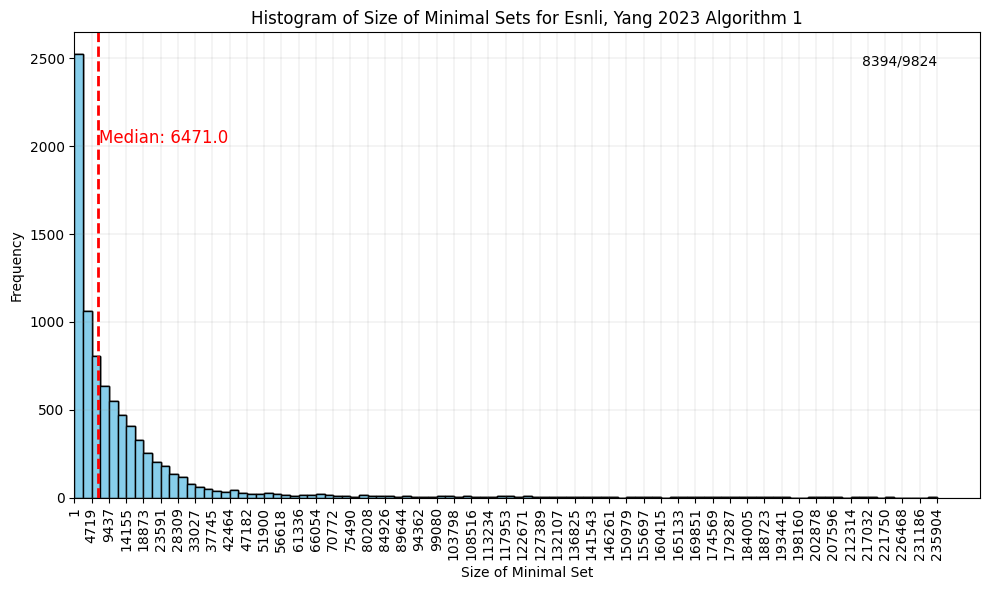

In [8]:
## Visualize Yang 2023 Algorithm1 
import pickle

with open (f"esnli_deberta_large_yang2023_alg1.pickle", 'rb') as handle:
    flip_list = pickle.load(handle)

num_examples = []
# compute some basic statistics
for i, l in enumerate(flip_list):
    if l is None:
        continue
    # compute the length of indices
    num_examples.append(len(l))

plot_histogram(
    dataset_name=DATASET_NAME,
    algo_name="Yang 2023 Algorithm 1",
    num_examples_per_subset=num_examples,
    test_labels=test_labels,
    bins=100,
    tick_threshold=100,
    tick_percentage_to_show=0.5,
    figsize=(10, 6)
)

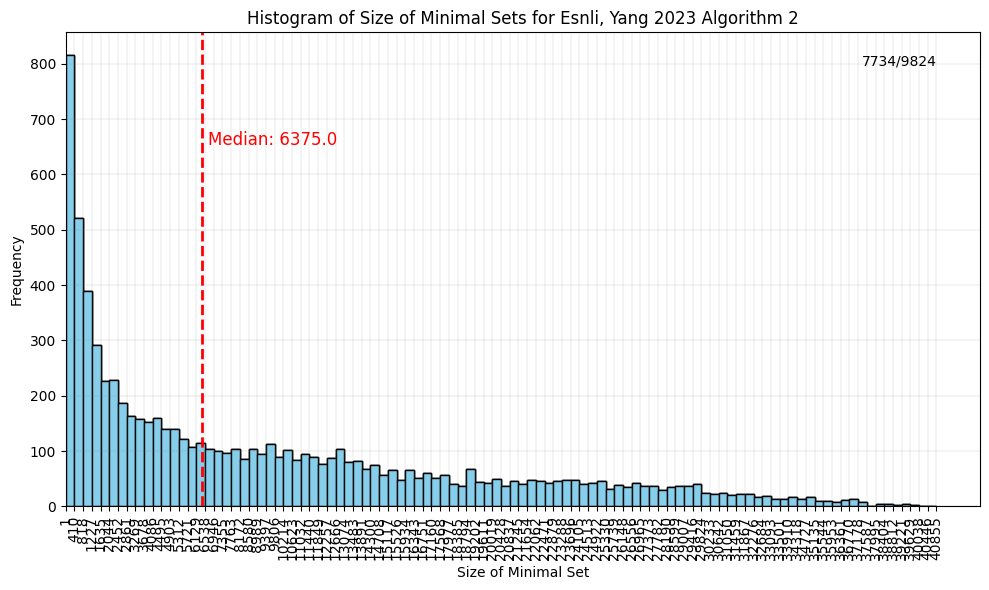

In [11]:
import pickle

# from utils.constants import RESULTS_DIR

# output_dir = RESULTS_DIR / "MinimalSubset"

with open (f"esnli_deberta_large_yang2023_alg2.pickle", 'rb') as handle:
    flip_list = pickle.load(handle)

num_examples = []
# compute some basic statistics
for i, l in enumerate(flip_list):
    if l is None or len(l) == 0:
        continue
    # compute the length of indices
    num_examples.append(len(l))

plot_histogram(
    dataset_name=DATASET_NAME,
    algo_name="Yang 2023 Algorithm 2",
    num_examples_per_subset=num_examples,
    test_labels=test_labels,
    bins=100,
    tick_threshold=100,
    tick_percentage_to_show=1.0,
    figsize=(10, 6)
)

In [3]:
## Visualize KNN
from utils.io import load_json
from tqdm import tqdm

data = load_json(f"{DATASET_NAME}_{MODEL_NAME}_KNN_minimal_subsets.json")

num_examples = []
for d in data:
    if d['minimum_subset']:
        num_examples.append(len(d['minimum_subset']))

plot_histogram(
    dataset_name=DATASET_NAME,
    algo_name="DeBerta KNN",
    num_examples_per_subset=num_examples,
    test_labels=test_labels,
    bins=100,
    tick_threshold=100,
    tick_percentage_to_show=0.5,
    figsize=(10, 6)
)

NameError: name 'plot_histogram' is not defined

In [5]:

# Investigate overlap in KNN
from utils.io import load_json
import pandas as pd

data = load_json(f"{DATASET_NAME}_{MODEL_NAME}_KNN_minimal_subsets.json")

# Dictionary to count occurrences
counts = {}

# Total number of entries
total_entries = len(data)

# Extract data and count occurrences
for entry in data:
    for num in entry["minimum_subset"]:
        if num in counts:
            counts[num] += 1
        else:
            counts[num] = 1

# Creating a DataFrame
df = pd.DataFrame(list(counts.items()), columns=['Number', 'Count'])

# Calculate frequency percentage
df['Frequency (%)'] = (df['Count'] / total_entries) * 100

# Sort by frequency in descending order
df = df.sort_values(by='Frequency (%)', ascending=False)

# Display the DataFrame
print(df)


        Number  Count  Frequency (%)
36595   238235   2021      20.572068
41194   238448   2020      20.561889
53901    72462   2020      20.561889
69581   309859   2019      20.551710
40716   372558   2019      20.551710
...        ...    ...            ...
452052  453537      1       0.010179
452051   66114      1       0.010179
452050  513622      1       0.010179
452049  451337      1       0.010179
479923  497704      1       0.010179

[479924 rows x 3 columns]


[238235, 238448, 72462, 309859, 372558, 437433, 179420, 115656, 32059, 61144]

In [35]:
dataset_dict['train'][1]

{'premise': 'A person on a horse jumps over a broken down airplane.',
 'hypothesis': 'A person is at a diner, ordering an omelette.',
 'label': 2,
 'explanation_1': 'One cannot be on a jumping horse cannot be a diner ordering food.',
 'explanation_2': None,
 'explanation_3': None,
 'text': 'Premise: A person on a horse jumps over a broken down airplane. Hypothesis: A person is at a diner, ordering an omelette.'}

In [32]:
from pprint import pprint

for e in df.head(2)['Number'].tolist():
    pprint(dataset_dict['train'][e])

{'explanation_1': 'Pets would not be allowed in a hospital.',
 'explanation_2': None,
 'explanation_3': None,
 'hypothesis': 'A lady pets her new dog.',
 'label': 2,
 'premise': 'A woman who just gave birth holding her baby in the hospital.',
 'text': 'Premise: A woman who just gave birth holding her baby in the '
         'hospital. Hypothesis: A lady pets her new dog.'}
{'explanation_1': 'A man sitting on a metal fence  and other one sits on a '
                  'bench.',
 'explanation_2': None,
 'explanation_3': None,
 'hypothesis': 'A man sits on a bench.',
 'label': 2,
 'premise': 'A man sitting on a metal fence overlooking the water and skyline.',
 'text': 'Premise: A man sitting on a metal fence overlooking the water and '
         'skyline. Hypothesis: A man sits on a bench.'}


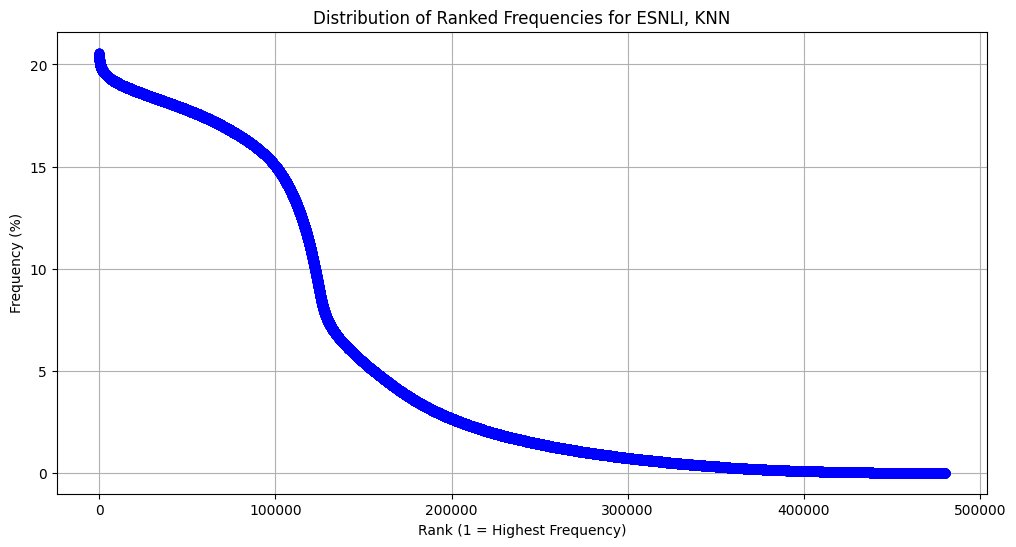

In [24]:
# Visualize top 100 examples 
df_subset = df.head(len(df.index)).reset_index(drop=True)
plt.figure(figsize=(12, 6))
# Plotting using the index + 1 as the x-axis (to start from 1 instead of 0)
plt.plot(df_subset.index + 1, df_subset['Frequency (%)'], marker='o', linestyle='-', color='b')
plt.xlabel('Rank (1 = Highest Frequency)')
plt.ylabel('Frequency (%)')
plt.title(f'Distribution of Ranked Frequencies for {DATASET_NAME.upper()}, KNN')
plt.grid(True)
# plt.xticks(range(1, len(df_subset) + 1))  # Ensure x-ticks match the number of entries
plt.show()

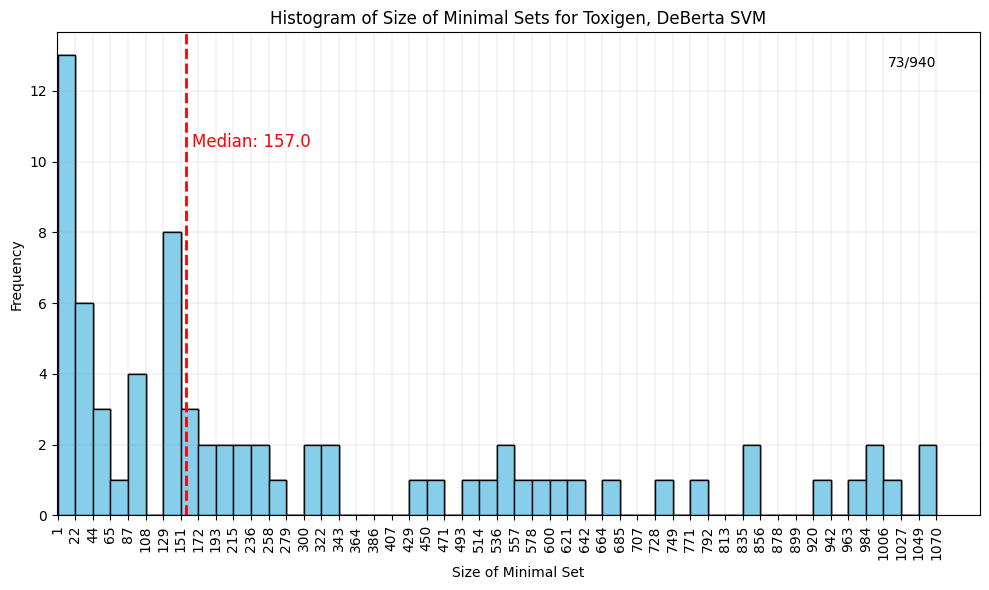

In [66]:
## Visualize SVM
from utils.io import load_json

data = load_json("toxigen_deberta_large_SVM_minimal_subsets.json")

num_examples = []
for d in data:
    if d['minimum_subset']:
        num_examples.append(len(d['minimum_subset']))

plot_histogram(
    dataset_name=DATASET_NAME,
    algo_name="DeBerta SVM",
    num_examples_per_subset=num_examples,
    test_labels=test_labels,
    bins=50,
    tick_threshold=100,
    tick_percentage_to_show=0.5,
    figsize=(10, 6)
)

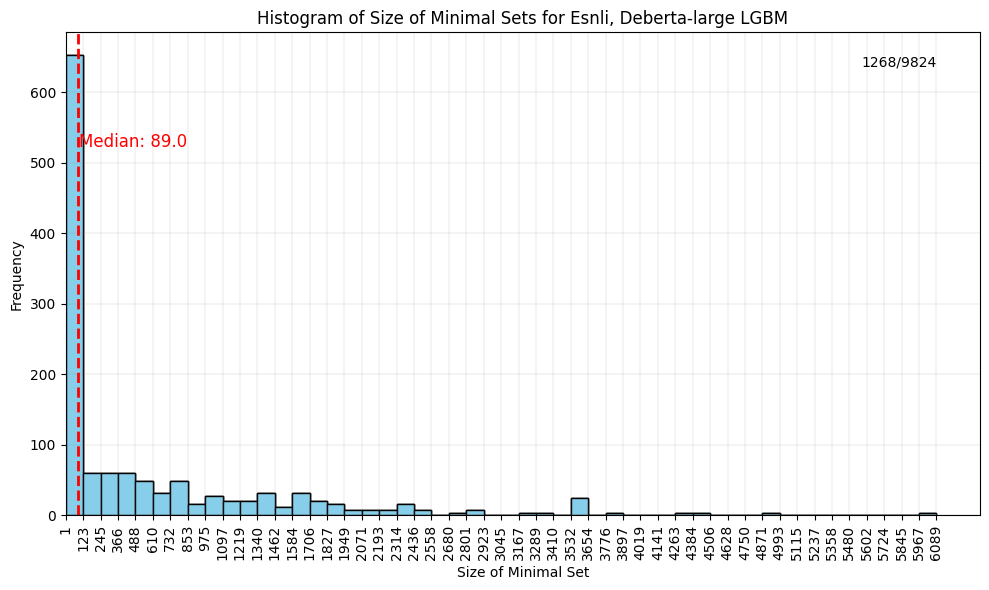

In [13]:
## Visualize DT
from utils.io import load_json
wrapper_name = "LGBM"

## NOTE: Used to process compiled subparts - uncomment as needed
# import os
# import json

# # Directory containing the JSON files
# directory = os.path.join(os.getcwd(), f"{wrapper_name}_compiled")

# # Initialize an empty list to hold all the data
# combined_data = []

# # Loop through all files in the directory
# for filename in sorted(os.listdir(directory)):
#     if filename.endswith('.json'):
#         file_path = os.path.join(directory, filename)
#         with open(file_path, 'r') as file:
#             data = json.load(file)
#             combined_data.extend(data)

# # Output file path
# output_file = os.path.join(f'esnli_deberta_large_{wrapper_name}_minimal_subsets.json')

# # Write the combined data to the output file
# with open(output_file, 'w') as file:
#     json.dump(combined_data, file, indent=4)

# print(f"Combined JSON data written to {output_file}")

data = load_json(f"{DATASET_NAME}_deberta_large_{wrapper_name}_minimal_subsets.json")

num_examples = []
for d in data:
    if d['minimum_subset']:
        num_examples.append(len(d['minimum_subset']))

plot_histogram(
    dataset_name=DATASET_NAME.upper(),
    algo_name=f"{MODEL_NAME.capitalize()} {wrapper_name.upper()}",
    num_examples_per_subset=num_examples,
    test_labels=test_labels,
    bins=50,
    tick_threshold=100,
    tick_percentage_to_show=0.5,
    figsize=(10, 6)
)

Unique values: [3, 16, 18, 23, 35, 42, 49, 60, 67, 119, 122, 144, 156, 176, 185, 187, 196, 199, 252, 297, 310, 318, 343, 373, 374, 394, 400, 410, 421, 439, 446, 457, 469, 508, 525, 531, 539, 548, 624, 657, 659, 685, 692, 696, 741, 832, 846, 863, 887, 931, 936, 973, 984, 1084, 1099, 1121, 1180, 1214, 1232, 1269, 1280, 1294, 1372, 1377, 1478, 1521, 1585, 1598, 1603, 1683, 1793, 1807, 1815, 1888, 1968, 1982, 2096, 2116, 2152, 2273, 2296, 2313, 2329, 2416, 2466, 2547, 2584, 2609, 2729, 2753, 2804, 2908, 2932, 2958, 3013, 3050, 3061, 3136, 3164, 3259, 3264, 3307, 3398, 3648, 3674, 3682, 3699, 3793, 3810, 3826, 3866, 3873, 3886, 4009, 4049, 4075, 4180, 4203, 4285, 4298, 4443, 4452, 4465, 4468, 4484, 4684, 4765, 4777, 4843, 4866, 4978, 5128, 5370, 5417, 5450, 5611, 5705, 5996, 6010, 6011, 6013, 6201, 6265, 6287, 6342, 6431, 6446, 6452, 6510, 6619, 6678, 6787, 6825, 6829, 6936, 6975, 6985, 7286, 7538, 7582, 7690, 7724, 7939, 8000, 8010, 8144, 8160, 8182, 8193, 8370, 8471, 8490, 8523, 8602, 860

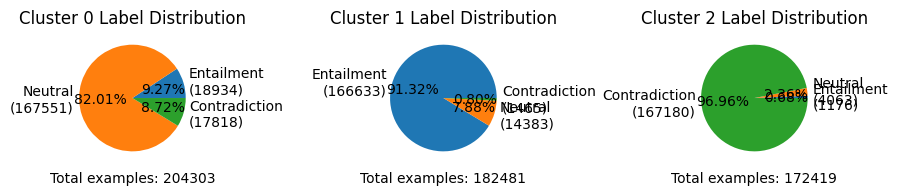

In [15]:
## Visualize LMeans
from tabulate import tabulate
from utils.io import load_json
from typing import Counter
import numpy as np
import pandas as pd

data = load_json("esnli_deberta_large_LMeans_minimal_subsets.json")

num_examples = []
for d in data:
    if d:
        num_examples.append(len(d))

# # LMeans is a bit special: looks like we only have ~15 unique 
# # subset values, so instead show frequency of thse values
# unique_values, counts = np.unique(num_examples, return_counts=True)
# print("Unique values:", unique_values.tolist())
# print("Counts:", counts)

# df = pd.DataFrame({'LMeans Unique Minimal Subset Sizes': unique_values, 'Counts': counts})

# print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))

In [18]:
len(data)

66946

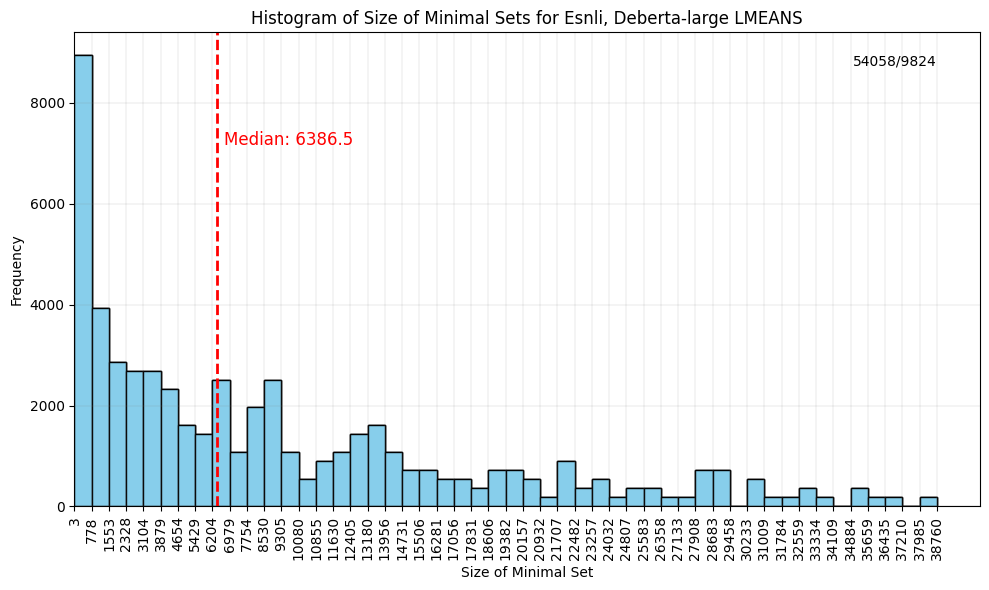

In [17]:
wrapper_name = "LMeans"
plot_histogram(
    dataset_name=DATASET_NAME.upper(),
    algo_name=f"{MODEL_NAME.capitalize()} {wrapper_name.upper()}",
    num_examples_per_subset=num_examples,
    test_labels=test_labels,
    bins=50,
    tick_threshold=100,
    tick_percentage_to_show=0.5,
    figsize=(10, 6)
)

In [ ]:
# Show Cluster Distribution
from utils.partition import get_partition_X
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, lmeans_clf.kmeans_.n_clusters, figsize=(9, 3))
n_clusters = lmeans_clf.kmeans_.n_clusters
for cluster_id, ax in zip(range(n_clusters), axs):
    _, train_indices = get_partition_X(lmeans_clf.kmeans_.labels_, cluster_id)
    cluster_labels = train_eval_labels[train_indices]
    unique_labels, label_counts = np.unique(cluster_labels, return_counts=True)
    
    # For plotting cluster distribution
    percents = [counts / np.sum(label_counts) for counts in label_counts ]
    labels = [
        f'{label.capitalize()}\n({count})'
        for label, p, count in zip(LABEL_SPACE, percents, label_counts)
    ]
    ax.pie(label_counts, labels = labels, autopct='%1.2f%%')
    ax.set_title(f'Cluster {cluster_id} Label Distribution')
    ax.text(
        0.5, -0.1, f'Total examples: {np.sum(label_counts)}', 
        horizontalalignment='center', 
        verticalalignment='center', transform=ax.transAxes
    )
plt.tight_layout()
plt.show()